# Experiment 1: Linear Feedback Validation with Moving Target Weights

Replicating the experiment from Aitchison et. al, where the Bayesian rule must learn a set of target weights over time, to validate that the rule is working as expected in Nengo.


In [23]:
import nengo
from nengo.processes import WhiteSignal
import numpy as np
import matplotlib.pyplot as plt
from learning_rules import Bayesian
from learning_rules.bayesian_rule import convert_log_to_linear

In Aitchison et al. target weights which change over time are implemented via an Ornstein-Uhlenbleck process. Here, this process is replicated based on their source code and the priors they use. Since they only run the experiment on one set of moving weights, this simulation will only involve connecting two neurons to each other.


In [24]:
# Generate time-evolving weights via OU process
def generate_ou_weights(n_weights, steps, dt, tau_ou, mu_ou, sigma_ou):
    target_weights = np.zeros((steps, n_weights))
    target_weights[0, :] = mu_ou 
    for t in range(1, steps):
        noise = np.random.randn(n_weights)
        target_weights[t, :] = target_weights[t-1, :] \
                               + (dt / tau_ou) * (mu_ou - target_weights[t-1, :]) \
                               + np.sqrt(2 * sigma_ou**2 * dt / tau_ou) * noise
    return target_weights

# Prior mean & variance for target weights, given in source code
m_ou, s2_ou = -0.6690, 0.07448
mu_ou, sigma2_ou = convert_log_to_linear(m_ou, s2_ou)

sigma_ou = np.sqrt(sigma2_ou)

# Using two neurons for one set of moving weights
n_a = 1
n_b = 1

dt = 0.001
T = 30.0
steps = int(T / dt)

# 1 set of moving target weights over time
n_weights = n_a * n_b
target_weights = generate_ou_weights(n_weights, steps, dt, tau_ou=1.0, mu_ou=mu_ou, sigma_ou=sigma_ou)

Set up the simulation with a simple input stim. Set up a Bayesian learning rule between neurons A and B.


In [ ]:
seed = 1000

model = nengo.Network()
with model:    
    # Two ensembles with one neuron each
    A = nengo.Ensemble(n_a, dimensions=1, seed=seed)
    B = nengo.Ensemble(n_b, dimensions=1)

    # Simple stim of 1
    stim = nengo.Node(lambda t: 1.0)

    nengo.Connection(stim, A)
    
    # Node to provide time-varying weights
    target_weight_node = nengo.Node(lambda t: target_weights[int(t / dt)] if int(t / dt) < steps else target_weights[-1])

    # Bayesian learning rule between A & B, using given priors
    learning_conn = nengo.Connection(
        A, B, 
        function=lambda x: [0],
        solver=nengo.solvers.NoSolver(weights=True),
        learning_rule_type=Bayesian(
            prior_mean = np.full((n_b, n_a), mu_ou), 
            prior_variance = np.full((n_b, n_a), sigma2_ou))
    )

    # Error node: ideal - output of B
    error = nengo.Node(lambda t, x: x[0] - x[1], size_in=2, size_out=1)
    nengo.Connection(target_weight_node, error[0])
    nengo.Connection(B, error[1])
    # scaled by epsilon due to abrupt scaling/update from one neuron firing
    nengo.Connection(error, learning_conn.learning_rule, transform=1e-7)

    error_probe = nengo.Probe(error, synapse=0.01)
    A_probe = nengo.Probe(A, synapse=0.01)
    B_probe = nengo.Probe(B, synapse=0.01)
    target_weights_probe = nengo.Probe(target_weight_node)
    learned_weights_probe = nengo.Probe(learning_conn, "weights")
    mean_probe = nengo.Probe(learning_conn.learning_rule, "mu")
    variance_probe = nengo.Probe(learning_conn.learning_rule, "sigma2")

with nengo.Simulator(model, dt=dt) as sim:
    sim.run(T)

Build finished in 0:00:01.                                                      
Simulation finished in 0:00:03.                                                 


Show results.


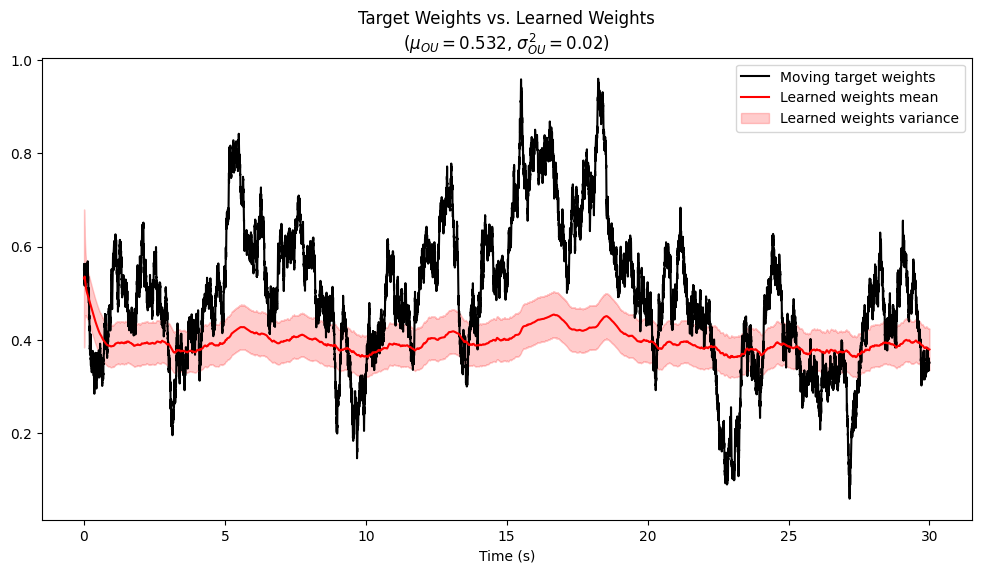

In [52]:
t = sim.trange()
target_weights = sim.data[target_weights_probe]
learned_weights = sim.data[learned_weights_probe]

mean = sim.data[mean_probe].flatten()
variance = sim.data[variance_probe].flatten()

std_dev = np.sqrt(variance)

plt.figure(figsize=(12, 6))
plt.plot(t, target_weights, color="black", label="Moving target weights")
plt.plot(t, mean, color="red", label="Learned weights mean")
plt.fill_between(t, mean - std_dev, mean + std_dev, color="red", alpha=0.2, label="Learned weights variance")
plt.xlabel("Time (s)")
plt.title(r"Target Weights vs. Learned Weights" 
          f"\n($\mu_{{OU}}={mu_ou:.3f}$, $\sigma^2_{{OU}}={sigma2_ou:.2f}$)")
plt.legend()
plt.show()